In [1]:
MODEL_CHECKPOINT_FILE = "../model_checkpoints/model-2018-12-20T09:19:07.cpkt"

In [2]:
import os

if not os.path.isfile(MODEL_CHECKPOINT_FILE):
    raise AssertionError('must set MODEL_CHECKPOINT_FILE')

In [3]:
!which python

/Users/aaron/Documents/github/ssd-pytorch/venv/bin/python


In [4]:
import sys
sys.path.append('..')

In [5]:
import enum
import math
import pdb
import platform
import time

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook
from albumentations import Compose, HorizontalFlip

from ssdmultibox import utils
from ssdmultibox.bboxer import Bboxer, TensorBboxer
from ssdmultibox.config import cfg
from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, device, TransformsTrainPascalFlatDataset
from ssdmultibox.models import SSDModel
from ssdmultibox.plotting import *
from ssdmultibox.predict import Predict
from ssdmultibox.utils import open_image

import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
plt.ion()

In [6]:
device

device(type='cpu')

In [7]:
str(device) == 'cpu'

True

In [8]:
model = SSDModel().to(device)

if str(device) == 'cpu':
    kwargs = {'map_location': 'cpu'}
else:
    kwargs = {}

model.load_state_dict(torch.load(MODEL_CHECKPOINT_FILE, **kwargs))
model.eval()

SSDModel(
  (vgg_base): VGGBase(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [9]:
# LR = 1e-2

# criterion = SSDLoss(alpha=100)
# optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
# current_time = time.time()

In [10]:
BATCH = 4

TransformsTrainPascalFlatDataset.__len__ = lambda self: BATCH

train_dataset = TransformsTrainPascalFlatDataset(
    transform=Compose([HorizontalFlip(p=0)],
                       bbox_params={'format': 'coco', 'label_fields': ['category_id']}))

len(train_dataset) 

4

In [11]:
train_dataset

In [12]:
NUM_WORKERS = 0
SHUFFLE = False
    
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

vars(dataloader)

{'dataset': <ssdmultibox.datasets.TransformsTrainPascalFlatDataset at 0x120491400>,
 'batch_size': 4,
 'num_workers': 0,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.SequentialSampler at 0x120491198>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x120491438>,
 '_DataLoader__initialized': True}

In [13]:
EPOCHS = 1

for epoch in range(EPOCHS):
    steps = math.ceil(len(train_dataset) / BATCH)
    for step in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        preds = model(ims)

In [14]:
bbs_preds, cats_preds = preds
idx = 0
cls_id = 6
dataset = train_dataset
model_output = image_ids, ims, gt_bbs, gt_cats

## single plots

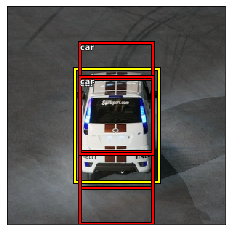

In [15]:
plot_anchor_bbs(model_output, idx, dataset)

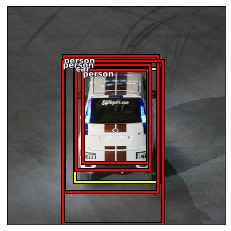

In [16]:
plot_preds(model_output, idx, dataset, preds)

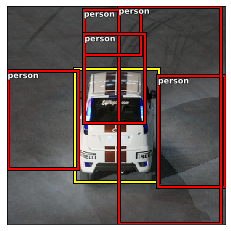

In [17]:
plot_nms_preds(model_output, idx, dataset, preds)

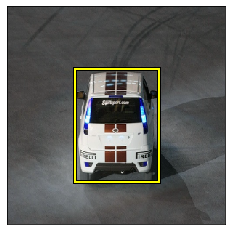

In [18]:
plot_nms_single_preds(model_output, idx, dataset, preds, cls_id)

## multiple plots

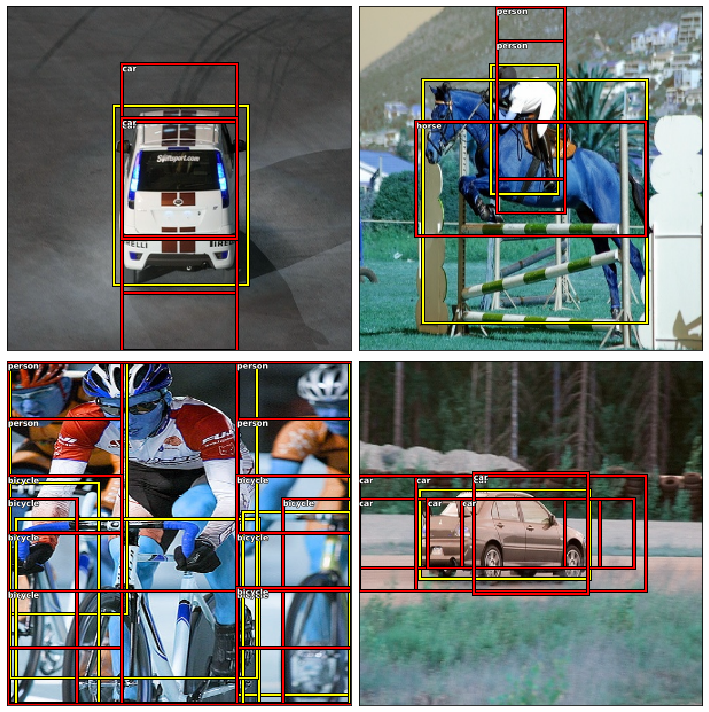

In [19]:
plot_multiple(plot_anchor_bbs, model_output=model_output, dataset=dataset)

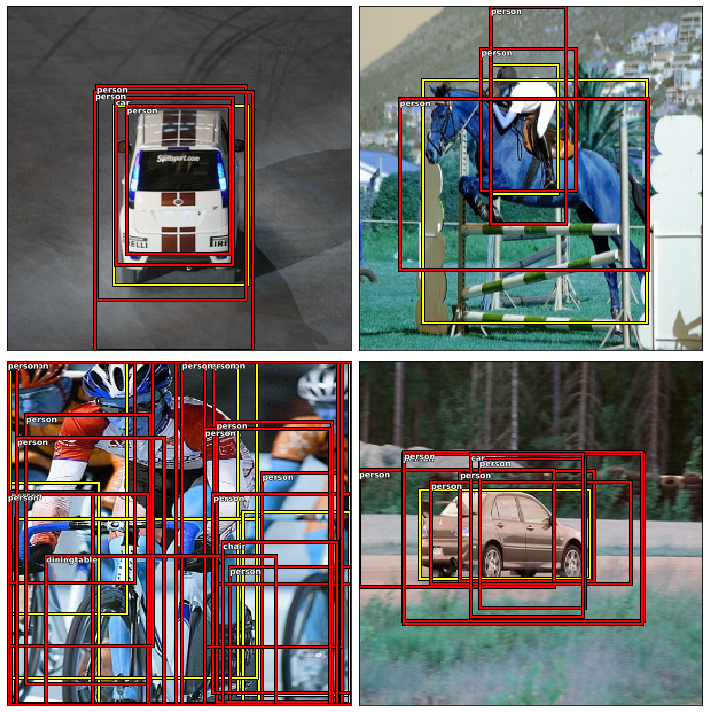

In [20]:
plot_multiple(plot_preds, model_output=model_output, dataset=dataset, preds=preds)

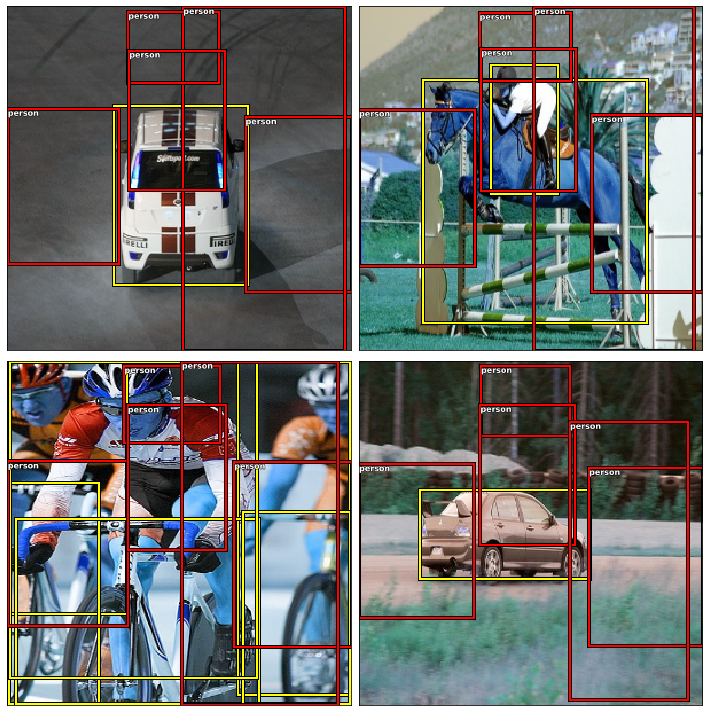

In [21]:
plot_multiple(plot_nms_preds, model_output=model_output, dataset=dataset, preds=preds)

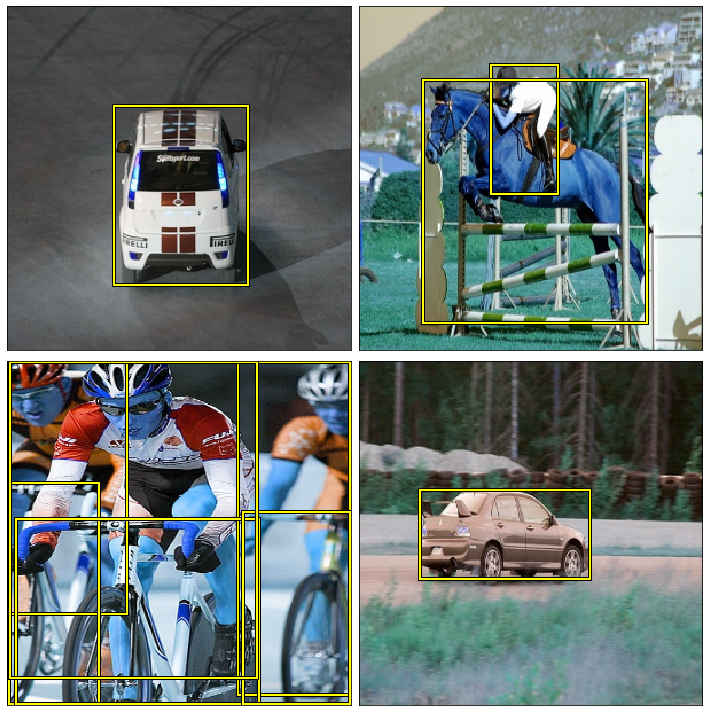

In [22]:
plot_multiple(plot_nms_single_preds, model_output=model_output, dataset=dataset, preds=preds, cls_id=cls_id)